# CA1 pyramidal cell model specifics
Specifics of the the parameterization for the morphologically detailed CA1 pyramidal cell used in the event-based encodings manuscript. 

This models uses morphology originally from https://doi.org/10.1002/cne.903620103 and hosted on NeuroMorpho.org (https://doi.org/10.1523/jneurosci.2055-07.2007).

The model is based off of Tom Morse's implementation: model 87284 on ModelDB.

Our implementation recieves stimuli independently from 15 excitatory and 15 inhibitory synapses at random locations in the cell's dendrites. 

In [2]:
import os
import numpy as np

from neuron import rxd
from neuron import h

from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import plotly

import sys
sys.path.insert(1, "../utils/")
import Stimuli, Pyr

## Single cell simulation

In [6]:
print('creating stimuli')
duration = 300

stim_params = Stimuli.ExperimentalStimParams()
stim_scaffold = stim_params.stim_scaffold['pyr']
segment_array = np.random.randint(0, 192, len(stim_scaffold['stim_type_array'])) 
    # 192 is the length of connection points
stimuli = Stimuli.MorphoStimuli('stimset0', stim_scaffold['stim_type_array'], segment_array, stim_scaffold, duration)
        
print('setting up cell')
pyr = Pyr.Pyr(vm_recording=True)
print('adding stimuli')
pyr.add_stimuli(stimuli)
print('running simulation')
pyr.run_simulation(duration)
print('simulation ended')

creating stimuli
setting up cell
adding stimuli
running simulation
simulation ended


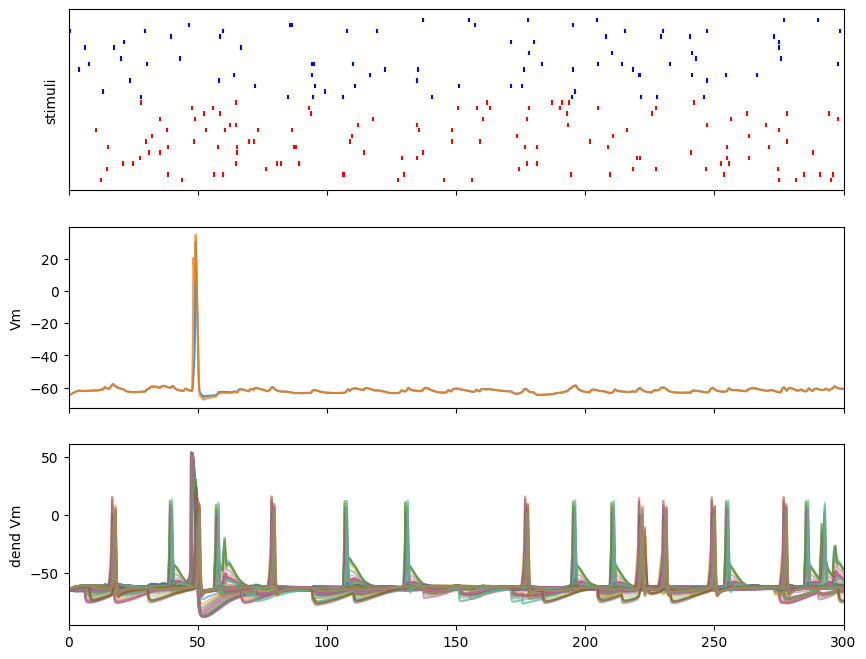

In [7]:
fig, axes = plt.subplots(3,1, figsize=(10, 8), sharex=True)

stimuli_colors = {
    'ex':'red',
    'in':'blue'
}

for i, stimulus in enumerate(stimuli.stimuli):
    axes[0].vlines(stimulus.event_times, i-0.4, i+0.4, color=stimuli_colors[stimulus._id])

for _v, seg_loc in zip(pyr._vs, pyr.all_seg_locs):
    if seg_loc == 'soma':
        axes[1].plot(pyr._t, _v, alpha=0.8)
    elif seg_loc == 'axon':
        axes[1].plot(pyr._t, _v, alpha=0.8)
    else:
        axes[2].plot(pyr._t, _v, alpha=0.5)
        
axes[0].set_yticks([])
axes[0].set_ylabel('stimuli')
axes[1].set_ylabel('Vm')
axes[2].set_ylabel('dend Vm')

axes[-1].set_xlim(0, duration)

plt.show()

## load seg locs
Seg locs refers to the segment locations of stimuli. Here, each seg_loc_file contains the locations of 15 excitatory and 15 inhibitory stimuli.

In [137]:
seg_locIDs = ['ID2','ID19','ID48','ID90','ID84','ID81','ID55','ID96','ID22','ID70',
              'ID21','ID36','ID25','ID50','ID99','ID88','ID92','ID69','ID87','ID71']
seg_loc_files = []
seg_loc_firing_rates = {}
for file in os.listdir('../data/morpho/segment_arrays/'):
    seg_locID = file.split('_')[3].strip('.npy')
    if seg_locID in seg_locIDs:
        seg_loc_files.append(file)
        seg_loc_firing_rates[seg_locID] = float(file.split('_')[2].strip('Hz'))

In [201]:
c = ListedColormap(["gold", "indigo", "deepskyblue", "darkorange"], N=4)
cmap=LinearSegmentedColormap.from_list("penguin", [c(i) for i in range(4)])

In [167]:
pyr = Pyr.Pyr()
section_locations = []
dist2soma = []
for seg in pyr.all_segs:
    for sec in seg:
        section_locations.append(seg.hname().split('.')[1].split('[')[0])

        dist2soma.append(h.distance(sec, pyr.cell.soma(0.5)))

In [168]:
pyr_color_map = {
    'soma': 0, #'indigo',
    'apic': 1, #'steelblue',
    'basal': 2 #:'red'
    'axon': 3, #'green',
}

all_segs_colors = [pyr_color_map[seg_loc] for seg_loc in section_locations]

In [169]:
cyt = rxd.Region(pyr.all_segs)
error = rxd.Parameter(cyt)

i = 0
for sec in pyr.all_segs:
    for seg in sec:   
        error.nodes(seg).value = all_segs_colors[i]
        i += 1

In [170]:
stim_types = Stimuli.ExperimentalStimParams().stim_scaffold['pyr']['stim_type_array']

stim_type2color = {
    'ex':'red',
    'in':'blue'
}

## 3D render of pyramidal
Used in bottom of figure 1 in the manuscript.

In [233]:
ps = h.PlotShape(False)
ps.variable(error)
ps.scale(0, 3)

ps2 = ps.plot(plotly, cmap=cmap)
ps2.update_layout(scene=dict(
    xaxis=dict(
        showticklabels=False,
        ticks='',
        title=''
    ),
    yaxis=dict(
        showticklabels=False,
        ticks='',
        title=''
    ),
    zaxis=dict(
        showticklabels=False,
        ticks='',
        title=''
    )
))

# draw the input locations
seg_locs = np.load(f'../data/morpho/segment_arrays/{seg_loc_files[5]}')
for stim_type, seg_loc in zip(stim_types, seg_locs):
    seg = pyr.connection_points[seg_loc]
    ps2.mark(seg(.5), marker_size=3, marker_color=stim_type2color[stim_type])
    
# redraw the soma
ps2.mark(pyr.cell.soma(0.5), marker_size=3, marker_color='green')

ps2.show()

## Figure 1 extras
Code below used to generate the legend and model firing rate diagram in the bottom of figure 1. 

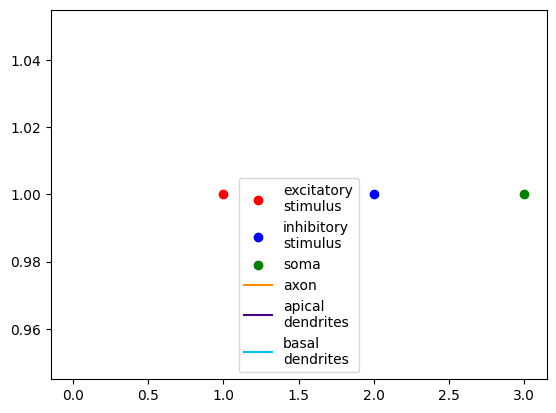

In [229]:
plt.scatter(1,1,c='red')
plt.scatter(2,1,c='blue')
plt.scatter(3,1,c='green')

plt.plot(0,1,c='darkorange')
plt.plot(0,1,c='indigo')
plt.plot(0,1,c='deepskyblue')



plt.legend(['excitatory\nstimulus','inhibitory\nstimulus', 'soma','axon','apical\ndendrites','basal\ndendrites'], ncol=1)
plt.savefig(f'{figures_dir}morpho3D_legend.svg', format='svg')

plt.show()

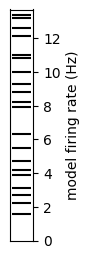

In [226]:
fig, axe = plt.subplots(1,figsize=(.3, 3))
axe.hlines(seg_loc_firing_rates.values(), .1, .9, color='k')

#axe.hlines(seg_loc_firing_rates['ID87'], 0, 1, color='green')

axe.set_xlim(0,1)
axe.set_ylim(0,13.7)
axe.yaxis.tick_right()
axe.yaxis.set_label_position("right")
axe.set_xticks([])
axe.set_ylabel('model firing rate (Hz)')

figures_dir = '../figures/'
plt.savefig(f'{figures_dir}morpho3D_firing_rates.svg', format='svg')
plt.show()

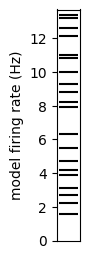

In [230]:
fig, axe = plt.subplots(1,figsize=(.3, 3))
axe.hlines(seg_loc_firing_rates.values(), .1, .9, color='k')

#axe.hlines(seg_loc_firing_rates['ID87'], 0, 1, color='green')

axe.set_xlim(0,1)
axe.set_ylim(0,13.7)
#axe.yaxis.tick_right()
#axe.yaxis.set_label_position("right")
axe.set_xticks([])
axe.set_ylabel('model firing rate (Hz)')

figures_dir = '../figures/'
plt.savefig(f'{figures_dir}morpho3D_firing_rates.svg', format='svg')
plt.show()